## <center> <b> <span style="color: #2f528f">  APARTMENT PRICE ANALYSIS IN HANOI
<center> <span style="color: #eb2d4b; font-family: Babas; font-size: 1.3em;">
 A data analysis personal project on Apartment prices in Hanoi <br>
 Based on 1,000+ listings crawled from the Alonhadat real estate website
 </span></center>


<b> <span style="font-family: Babas; font-size: 1.8em;"> Contents
* [Crawl data](#chapter1)
* [Data Cleaning and Transformation](#chapter2)
* [Exploratory Data Analysis](#chapter3)

<h2> 1. Crawl Data from Alonhadat Website</h1> <a class="anchor" id="chapter1">


In [1]:
!pip install selenium
!pip install webdriver-manager

In [ ]:
import re, time, pandas as pd, unicodedata
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC


TODAY = "16/10/2025"
YESTERDAY = "15/10/2025"

# --------------------
def is_captcha_page(driver):
    try:
        #tín hiệu 
        notice = driver.find_element(By.XPATH, "//*[contains(.,'Tôi không phải người máy')]")
        btn = driver.find_element(By.XPATH, "//button[normalize-space()='Xác thực']")
        return True
    except NoSuchElementException:
        return False

def wait_until_captcha_cleared(driver, max_wait_secs=300):
    if not is_captcha_page(driver):
        return
    print("Gặp trang xác thực.")
    end = time.time() + max_wait_secs
    while time.time() < end:
        if not is_captcha_page(driver):
            print("Đã qua captcha, tiếp tục crawl.")
            return
        time.sleep(2)
        
def num_first(text):
    if not text: return None
    m = re.search(r"\d+(?:[\.,]\d+)?", text.replace(" ", ""))
    return m.group(0).replace(",", ".") if m else None

def clean_area_m2_from_article(art):
    try:
        val = art.find_element(By.XPATH, ".//span[contains(@class,'area')]//span[@itemprop='value']").text.strip()
        unit = art.find_element(By.XPATH, ".//span[contains(@class,'area')]//span[@itemprop='unitText']").text.strip()
        n = num_first(val)
        return float(n) if (n and "m" in unit.lower()) else None
    except:
        return None

def extract_int(text):
    n = num_first(text)
    return int(float(n)) if n else None

def parse_price_to_ty(price_text, area_m2):
    if not price_text:
        return None
    t = unicodedata.normalize("NFKC", price_text).lower()
    t = t.replace(",", ".").replace("m²", "m2")
    t_compact = re.sub(r"\s+", "", t)
    # "triệu/m2" -> nhân diện tích, chia 1000 để ra tỷ
    if "triệu/m2" in t_compact:
        n = re.search(r"([\d\.]+)", t)
        return round((float(n.group(1)) * float(area_m2) / 1000.0), 3) if (n and area_m2) else None
    # "tỷ"
    if "tỷ" in t:
        n = re.search(r"([\d\.]+)", t)
        return round(float(n.group(1)), 3) if n else None
    # "triệu"
    if "triệu" in t:
        n = re.search(r"([\d\.]+)", t)
        return round(float(n.group(1)) / 1000.0, 3) if n else None
    return None

def get_text_or_empty(el, xpath):
    try: return el.find_element(By.XPATH, xpath).text.strip()
    except: return ""

# ---------- Crawl ----------
service = Service(ChromeDriverManager().install())
browser = webdriver.Chrome(service=service)
wait = WebDriverWait(browser, 15)
rows = []

for p in range(1, 101):
    url = "https://alonhadat.com.vn/can-ban-can-ho-chung-cu" if p == 1 else f"https://alonhadat.com.vn/can-ban-can-ho-chung-cu/trang-{p}"
    print(f"\n=== Crawl Page {p} ===\n{url}")
    browser.get(url)
    wait_until_captcha_cleared(browser)

    try:
        wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "article.property-item")))
    except TimeoutException:
        print(f" Timeout waiting for page {p}, skipping...")
        continue

    articles = browser.find_elements(By.CSS_SELECTOR, "article.property-item")
    print("Found:", len(articles), "articles")

    for art in articles:
        # Ngày đăng
        date_text = get_text_or_empty(art, ".//time[contains(@class,'created-date')]")
        if date_text:
            low = date_text.lower()
            if low.startswith("hôm nay"):
                date = TODAY
            elif low.startswith("hôm qua"):
                date = YESTERDAY
            else:
                date = date_text
        else:
            date = ""

        # Thông tin cơ bản
        title = get_text_or_empty(art, ".//h3[contains(@class,'property-title')]")
        price_text = get_text_or_empty(art, ".//span[contains(@class,'price')]")
        area_m2 = clean_area_m2_from_article(art)
        price_ty = parse_price_to_ty(price_text, area_m2)
        
        bedrooms_txt = get_text_or_empty(art, ".//span[contains(@class,'bedroom')]//span[@itemprop='value']")
        bedrooms = extract_int(bedrooms_txt)

        parking_name = get_text_or_empty(art, ".//span[contains(@class,'parking')]//span[@itemprop='name']")
        parking = "1" if parking_name.lower().startswith("chỗ để xe") else "0"

        direction = get_text_or_empty(art, ".//span[contains(@class,'direction')]")
        road_width = get_text_or_empty(art, ".//span[contains(@class,'road-width')]")
    
        street = get_text_or_empty(art, ".//p[contains(@class,'new-address')]//span[@itemprop='streetAddress']")
        ward   = get_text_or_empty(art, ".//p[contains(@class,'new-address')]//span[@itemprop='addressLocality']")
        region = get_text_or_empty(art, ".//p[contains(@class,'new-address')]//span[@itemprop='addressRegion']")
        old_address = get_text_or_empty(art, ".//p[contains(@class,'old-address')]")

        rows.append({
            "page": p,
            "title": title,
            "date": date,
            "price_raw": price_text,
            "price_ty": price_ty,
            "area_m2": area_m2,
            "bedrooms": bedrooms,
            "parking": parking,
            "street": street,
            "ward": ward,
            "region": region,
            "old_address": old_address
        })

    time.sleep(1.5)  

browser.quit()

df = pd.DataFrame(rows)
print("\nPreview:")
print(df.head())

df.to_csv("alonhadat_listing.csv", index=False, encoding="utf-8-sig")
print("\ Saved", len(df), "rows -> alonhadat_listing.csv")


<h2> 2. Data Cleaning & Transformation <a class="anchor" id="chapter2">

In [257]:
import pandas as pd

df = pd.read_csv("alonhadat_listing.csv")
print("Số dòng:", len(df))
print("\n=== Thông tin cột (info) ===")
print(df.info())



Số dòng: 2000

=== Thông tin cột (info) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   page         2000 non-null   int64  
 1   title        2000 non-null   object 
 2   date         2000 non-null   object 
 3   price_raw    2000 non-null   object 
 4   price_ty     1999 non-null   float64
 5   area_m2      2000 non-null   float64
 6   floors       1344 non-null   float64
 7   bedrooms     1969 non-null   float64
 8   parking      2000 non-null   int64  
 9   direction    293 non-null    object 
 10  road_width   0 non-null      float64
 11  street       1959 non-null   object 
 12  ward         1991 non-null   object 
 13  region       2000 non-null   object 
 14  old_address  2000 non-null   object 
dtypes: float64(5), int64(2), object(8)
memory usage: 234.5+ KB
None


In [258]:
region_counts = df["region"].value_counts()

print("Số lượng dữ liệu theo từng tỉnh/thành phố:")
print(region_counts)

Số lượng dữ liệu theo từng tỉnh/thành phố:
region
Hà Nội         1523
Hồ Chí Minh     240
Đà Nẵng         121
Huế              21
Tây Ninh         15
Nghệ An          15
Gia Lai          14
Hải Phòng        13
Khánh Hòa         9
Hưng Yên          7
Bắc Ninh          6
Ninh Bình         4
Lâm Đồng          3
Cần Thơ           3
Đắk Lắk           2
Phú Thọ           1
Quảng Ninh        1
Lào Cai           1
Đồng Nai          1
Name: count, dtype: int64


#### Lý do chọn dữ liệu Hà Nội 

- Phân bố theo vùng mất cân bằng mạnh: HN = 1,523, trong khi các tỉnh khác chỉ vài chục → không đủ tin cậy để so sánh liên vùng.
- Mục tiêu dự án: nghiên cứu thị trường căn hộ tại Hà Nội.

#### Xử lý 

- Chỉ giữ dữ liệu Hà Nội: region == "Hà Nội".
- Loại bỏ cột thiếu dữ liệu nghiêm trọng và cột không cần thiết:
  * road_width (0/2000 non-null) → drop
  * direction (293/2000 non-null) → drop
  * price_raw (đã có biến price) → drop
  * date (ngày đăng - không phân tích được do ít giá trị), page(số trang khi crawl), region (chỉ có HN) → drop
- Loại các dòng thiếu trường trọng yếu:
  * Bỏ dòng thiếu price_ty (giá), bedrooms (phân khúc), hoặc ward (phường) vì ảnh hưởng trực tiếp đến phân tích.
- Chuẩn bị thêm biến phục vụ EDA:
  * price_per_m2 = price_ty * 1000 / area_m2


In [259]:
df = df[df["region"] == "Hà Nội"]
df = df.drop(columns=["road_width",'direction','price_raw','date','region','page'])
df = df.dropna(subset=["price_ty",'ward','bedrooms'])
df["price_per_m2"] = df["price_ty"] * 1000 / df["area_m2"]


#### Tạo thêm biến district từ old_address để phân tích

In [260]:
import re
import unicodedata
import pandas as pd

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = unicodedata.normalize("NFKC", s)  # chuẩn Unicode
    s = s.replace("\xa0", " ")  # ký tự space đặc biệt
    s = re.sub(r"\s+", " ", s).strip()
    return s

# --- trích tên quận/huyện/thị xã ---
def extract_district_from_old(old_address: str) -> str:
    s = normalize_text(old_address)
    if not s:
        return ""
    patterns = [
        r"(?:Quận|Q\.)\s*([A-Za-zÀ-ỹ\s\-]+?)(?:,|$)",
        r"(?:Huyện|H\.)\s*([A-Za-zÀ-ỹ\s\-]+?)(?:,|$)",
        r"(?:Thị\s*xã|TX)\s*([A-Za-zÀ-ỹ\s\-]+?)(?:,|$)"
    ]

    for pat in patterns:
        m = re.search(pat, s)
        if m:
            return normalize_text(m.group(1))

    return ""


In [261]:
df["district"] = df["old_address"].apply(extract_district_from_old)
print(df[["old_address", "district"]].head(10))

                                          old_address      district
2   Đường Nguyễn Quốc Trị, Phường Trung Hòa, Quận ...      Cầu Giấy
4   Đường Giải Phóng, Phường Thịnh Liệt, Quận Hoàn...     Hoàng Mai
6   Đường Xuân La, Phường Xuân La, Quận Tây Hồ, Hà...        Tây Hồ
19  Phố Lạc Trung, Phường Thanh Nhàn, Quận Hai Bà...  Hai Bà Trưng
22  Phố Văn Cao, Phường Liễu Giai, Quận Ba Đình, H...       Ba Đình
27  Đường Định Công, Phường Định Công, Quận Hoàng ...     Hoàng Mai
30  Đường Đình Thôn, Phường Mỹ Đình 1, Quận Nam Từ...   Nam Từ Liêm
31  Đại lộ Thăng Long, Xã Thạch Hòa, Huyện Thạch T...    Thạch Thất
34  Đường Đình Thôn, Phường Mỹ Đình 1, Quận Nam Từ...   Nam Từ Liêm
35  Đường Hồ Đền Lừ, Phường Hoàng Văn Thụ, Quận Ho...     Hoàng Mai


#### Thêm biến urban_district để gắn nhãn các quận/huyện nội thành và ngoại thành


In [263]:

import pandas as pd
import re, unicodedata

# danh sách phường 
district_counts = df["district"].value_counts().sort_index()
print("Danh sách district (Hà Nội)\n")
print(district_counts)

# chỉ list tên phường cũ:
districts_list = district_counts.index.tolist()
print("\nTổng số quấn/huyện:", len(districts_list))
print(districts_list)


Danh sách district (Hà Nội)

district
Ba Đình          55
Bắc Từ Liêm      81
Cầu Giấy        306
Gia Lâm           4
Hai Bà Trưng    114
Hoài Đức         10
Hoàn Kiếm         7
Hoàng Mai       153
Hà Đông         114
Long Biên        73
Nam Từ Liêm     279
Thanh Trì        15
Thanh Xuân      109
Thạch Thất        1
Tây Hồ           50
Đan Phượng       12
Đông Anh          4
Đống Đa         112
Name: count, dtype: int64

Tổng số quấn/huyện: 18
['Ba Đình', 'Bắc Từ Liêm', 'Cầu Giấy', 'Gia Lâm', 'Hai Bà Trưng', 'Hoài Đức', 'Hoàn Kiếm', 'Hoàng Mai', 'Hà Đông', 'Long Biên', 'Nam Từ Liêm', 'Thanh Trì', 'Thanh Xuân', 'Thạch Thất', 'Tây Hồ', 'Đan Phượng', 'Đông Anh', 'Đống Đa']


In [264]:
import pandas as pd
import numpy as np

# Tập 12 quận nội thành 
URBAN_DISTRICTS = {
    "Ba Đình", "Hoàn Kiếm", "Đống Đa", "Hai Bà Trưng",
    "Tây Hồ", "Cầu Giấy", "Thanh Xuân", "Hoàng Mai",
    "Long Biên", "Nam Từ Liêm", "Bắc Từ Liêm", "Hà Đông"
}

# Chuẩn hoá chuỗi district
df["district"] = (
    df["district"]
    .astype(str)
    .str.replace("\u00a0", " ")
    .str.strip()
)

df["urban_district"] = np.where(
    df["district"].isin(URBAN_DISTRICTS),
    1,
    np.where(
        df["district"].eq("") | df["district"].isna(),
        np.nan,
        0
    )
)

# Kiểm tra
print(df[["district", "urban_district"]].head(10))
print("\nTổng số nội/ngoại thành:")
print(df["urban_district"].value_counts(dropna=False))


        district  urban_district
2       Cầu Giấy             1.0
4      Hoàng Mai             1.0
6         Tây Hồ             1.0
19  Hai Bà Trưng             1.0
22       Ba Đình             1.0
27     Hoàng Mai             1.0
30   Nam Từ Liêm             1.0
31    Thạch Thất             0.0
34   Nam Từ Liêm             1.0
35     Hoàng Mai             1.0

Tổng số nội/ngoại thành:
urban_district
1.0    1453
0.0      46
Name: count, dtype: int64


#### Xóa các quận/huyện có quá ít dữ liệu <10

In [265]:
district_counts = df["district"].value_counts()
valid_districts = district_counts[district_counts >= 10].index

df = df[df["district"].isin(valid_districts)]
print("Số quận đủ dữ liệu:", len(valid_districts))


Số quận đủ dữ liệu: 14


In [266]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1483 entries, 2 to 1999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1483 non-null   object 
 1   price_ty        1483 non-null   float64
 2   area_m2         1483 non-null   float64
 3   floors          987 non-null    float64
 4   bedrooms        1483 non-null   float64
 5   parking         1483 non-null   int64  
 6   street          1461 non-null   object 
 7   ward            1483 non-null   object 
 8   old_address     1483 non-null   object 
 9   price_per_m2    1483 non-null   float64
 10  district        1483 non-null   object 
 11  urban_district  1483 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 150.6+ KB
None
          price_ty      area_m2      floors     bedrooms      parking  \
count  1483.000000  1483.000000  987.000000  1483.000000  1483.000000   
mean      7.460299    93.116655    8.986829     2.770

####  Kiểm tra các giá trị max/outliers của area_m2, floors, bedrooms

In [267]:
area_outlier = df[(df["area_m2"] >300)  | (df["floors"] >50) | (df["bedrooms"] >5) ]
print(area_outlier[["title", "price_ty", "area_m2",'bedrooms','floors']])

                                                  title  price_ty  area_m2  \
90    Siêu phẩm biệt thự trên không The Manor Mễ Trì...      35.0    380.0   
424   CHỈ VỚI PHÂN KHÚC 27 TỶ - CÓ NGAY CĂN PENHOUSE...      27.0    320.0   
426   ANH TRAI NHỜ BÁN CĂN BIỆT THỰ LÔ GÓC 410M2 - T...      22.0    410.0   
556   BÁN CĂN HỘ PENTHOUSE CHUNG CƯ HANOI AQUA CENTR...     100.0    500.0   
558   BÁN CĂN HỘ PENTHOUSE CHUNG CƯ 250 MINH KHAI - ...      48.0    560.0   
736   Penhouse Duplex Tú Mỡ, lô góc, bể bơi, sân vườ...      35.7    405.0   
920   Bán Duplex Petrowaco 97 - 99 Láng Hạ 350m2 giá...      31.0    350.0   
928   Bán căn Duplex GOLDEN WESTLAKE Thuỵ Khuê 305m2...      50.5    305.0   
990   Bán căn Duplex 4PN-5WC 350m2 tòa Green Diamond...      59.9    350.0   
1000  Bán căn Duplex 4PN-5WC 350m2 tòa Green Diamond...      59.9    350.0   
1128  Bán Dòng Tiền CCMN Lê Đức Thọ 9 Tầng 41 Căn Hộ...      50.0    160.0   
1129  Bán Tòa Căn Hộ Dòng Tiền Quận Đống Đa 248m2 Xâ...      75.

- Xóa các dòng dữ liệu 'bán tòa căn hộ' thay vì căn hộ chung cư - gồm các căn có bedrooms >=10
- Xóa cột floors vì dữ liệu không đồng nhất, nhiều dòng floors =1,2 và thiếu nhiều dữ liệu.

In [268]:
drop = (
    (df["bedrooms"] >=10))
df = df[~drop]
df = df.drop(columns=["floors"])

#### Xóa các giá trị outlier (penhouse, villa,...) theo price_ty > 50 tỷ và area_m2 >300 m2

In [269]:
area_outlier = df[(df["price_ty"] >50) | (df["area_m2"] >300)]
print(area_outlier[["title", "price_ty", "area_m2", 'bedrooms']])

                                                  title  price_ty  area_m2  \
90    Siêu phẩm biệt thự trên không The Manor Mễ Trì...     35.00    380.0   
424   CHỈ VỚI PHÂN KHÚC 27 TỶ - CÓ NGAY CĂN PENHOUSE...     27.00    320.0   
426   ANH TRAI NHỜ BÁN CĂN BIỆT THỰ LÔ GÓC 410M2 - T...     22.00    410.0   
556   BÁN CĂN HỘ PENTHOUSE CHUNG CƯ HANOI AQUA CENTR...    100.00    500.0   
558   BÁN CĂN HỘ PENTHOUSE CHUNG CƯ 250 MINH KHAI - ...     48.00    560.0   
726   Căn hộ CC VINCOM BÀ TRIỆU 300M 5NGỦ – TẶNG FUL...     53.50    300.0   
736   Penhouse Duplex Tú Mỡ, lô góc, bể bơi, sân vườ...     35.70    405.0   
920   Bán Duplex Petrowaco 97 - 99 Láng Hạ 350m2 giá...     31.00    350.0   
928   Bán căn Duplex GOLDEN WESTLAKE Thuỵ Khuê 305m2...     50.50    305.0   
985   Bán CHCC 116m2 3PN 2WC Bamboo Airways Tower, 2...     99.96    116.0   
990   Bán căn Duplex 4PN-5WC 350m2 tòa Green Diamond...     59.90    350.0   
1000  Bán căn Duplex 4PN-5WC 350m2 tòa Green Diamond...     59.9

In [270]:
# Lọc các căn quá đắt và quá rộng(biệt thự, penhouse, duplex,...)
before = len(df)
df_filtered = df[(df["price_ty"] <= 50) & (df["area_m2"] <= 300)  ].copy()
after = len(df_filtered)
removed = before - after
print(f"Removed {removed} listings with price > 50 tỷ và diện tích <300m2")
print(f"Remaining: {after}")


Removed 14 listings with price > 50 tỷ và diện tích <300m2
Remaining: 1461


In [272]:

df_filtered.to_csv("alonhadat_listing_cleaned.csv", index=False, encoding="utf-8-sig")

## 3. Exploratory Data Analysis <a class="anchor" id="chapter3">

#### Tổng quan

In [273]:
print(df_filtered.info())
print(df_filtered.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1461 entries, 2 to 1998
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1461 non-null   object 
 1   price_ty        1461 non-null   float64
 2   area_m2         1461 non-null   float64
 3   bedrooms        1461 non-null   float64
 4   parking         1461 non-null   int64  
 5   street          1439 non-null   object 
 6   ward            1461 non-null   object 
 7   old_address     1461 non-null   object 
 8   price_per_m2    1461 non-null   float64
 9   district        1461 non-null   object 
 10  urban_district  1461 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 137.0+ KB
None
          price_ty      area_m2     bedrooms      parking  price_per_m2  \
count  1461.000000  1461.000000  1461.000000  1461.000000   1461.000000   
mean      6.852747    90.602327     2.579055     0.422998     74.970006   
std       3.453250 

#### Các biến phân loại (bedrooms, parking, urban_district, district)

C:\Users\ADM\AppData\Local\Temp\ipykernel_38132\4038954812.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=col, palette="Blues_r", order=df_filtered[col].value_counts().index)
C:\Users\ADM\AppData\Local\Temp\ipykernel_38132\4038954812.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=col, palette="Blues_r", order=df_filtered[col].value_counts().index)
C:\Users\ADM\AppData\Local\Temp\ipykernel_38132\4038954812.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x=col, pa

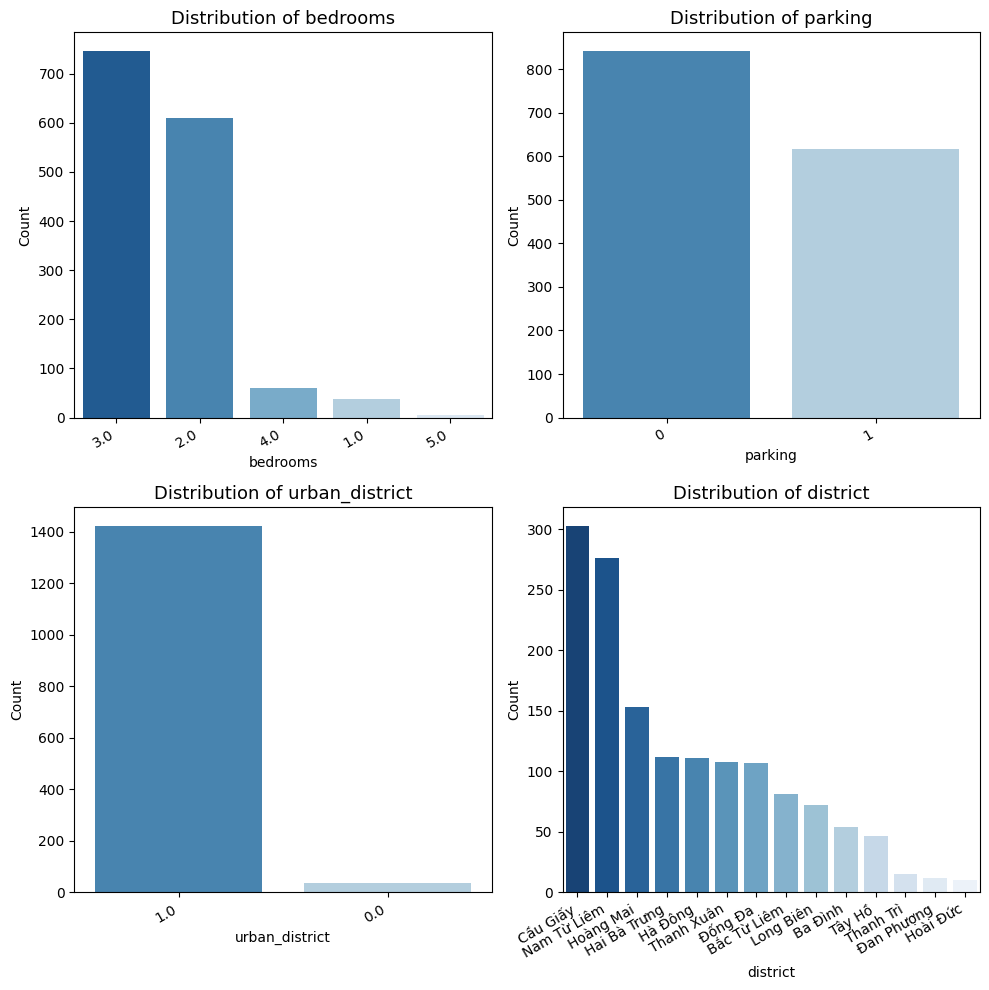

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = pd.read_csv("alonhadat_listing_cleaned.csv")
cat_vars = ["bedrooms", "parking", "urban_district", "district"]

plt.figure(figsize=(10, 10))

for i, col in enumerate(cat_vars, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df_filtered, x=col, palette="Blues_r", order=df_filtered[col].value_counts().index)
    plt.title(f"Distribution of {col}", fontsize=13)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()


#### Các biến số (price_ty, price_per_m2, area_m2)

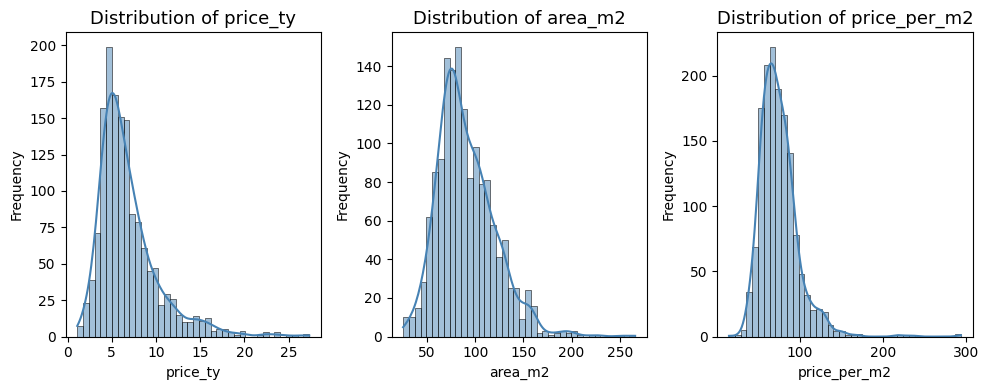

In [275]:
num_vars = ["price_ty", "area_m2", "price_per_m2"]

plt.figure(figsize=(10, 4))

for i, col in enumerate(num_vars, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df_filtered, x=col, kde=True, color="steelblue", bins=40)
    plt.title(f"Distribution of {col}", fontsize=13)
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


#### So sánh giá trung bình (triệu/m²) giữa Nội thành và Ngoại thành

C:\Users\ADM\AppData\Local\Temp\ipykernel_38132\550189639.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x="urban_district", y="price_per_m2", palette="coolwarm")


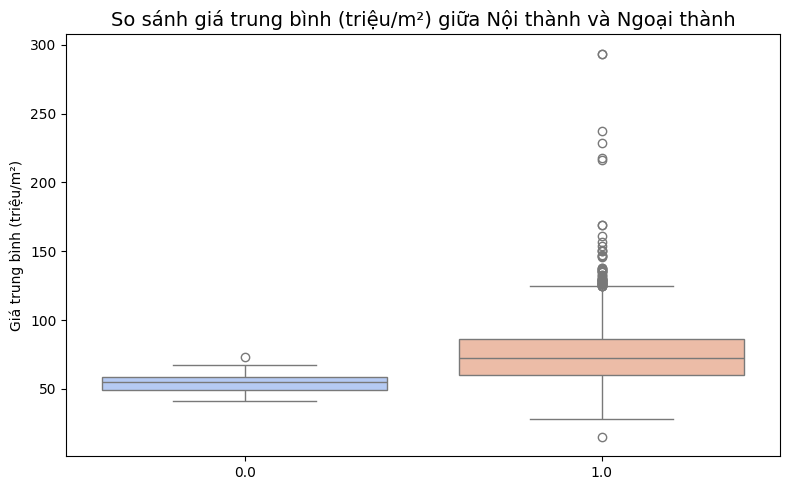

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=df_filtered, x="urban_district", y="price_per_m2", palette="coolwarm")
plt.title("So sánh giá trung bình (triệu/m²) giữa Nội thành và Ngoại thành", fontsize=14)
plt.xlabel("")
plt.ylabel("Giá trung bình (triệu/m²)")
plt.tight_layout()
plt.show()


#### So sánh giá trung bình (triệu/m²) giữa có chỗ đỗ xe và không có chỗ đỗ xe

C:\Users\ADM\AppData\Local\Temp\ipykernel_38132\2941109614.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x="parking", y="price_per_m2", palette="coolwarm")


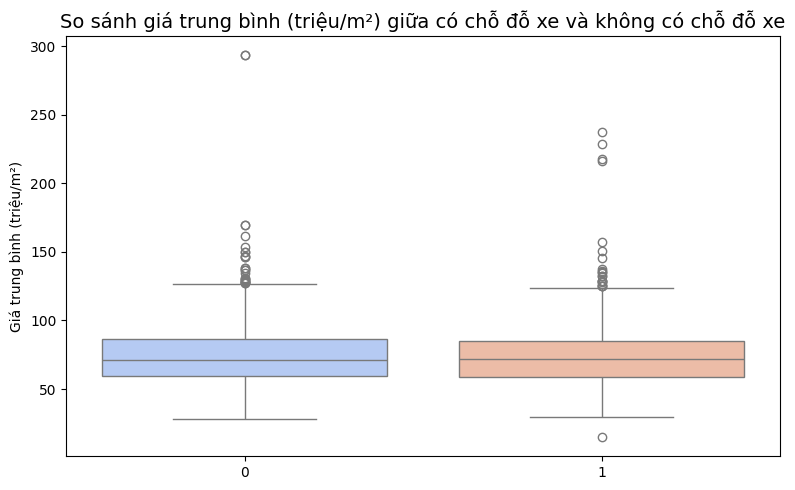

In [277]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=df_filtered, x="parking", y="price_per_m2", palette="coolwarm")
plt.title("So sánh giá trung bình (triệu/m²) giữa có chỗ đỗ xe và không có chỗ đỗ xe", fontsize=14)
plt.xlabel("")
plt.ylabel("Giá trung bình (triệu/m²)")
plt.tight_layout()
plt.show()


- Biểu đồ không cho thấy sự khác biệt rõ ràng về giá giữa các căn hộ có hoặc không có chỗ để xe.
- Tuy nhiên, điều này không phản ánh thực mà chủ yếu do người dùng đăng bài trên Alonhadat không gắn đủ nhãn "parking". Theo mặc định, những bài thiếu thông tin được gán là “không có chỗ để xe”, dẫn đến sai lệch dữ liệu và làm giảm ý nghĩa của biến.
- Kết luận: loại bỏ biến parking khỏi phân tích.

#### Xóa parking

In [278]:
df_filtered = df_filtered.drop(columns=['parking'])
df_filtered.to_csv("alonhadat_listing_cleaned.csv", index=False, encoding="utf-8-sig")

#### Phân phối giá mỗi m² theo quận/huyện Hà Nội

C:\Users\ADM\AppData\Local\Temp\ipykernel_38132\681401900.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


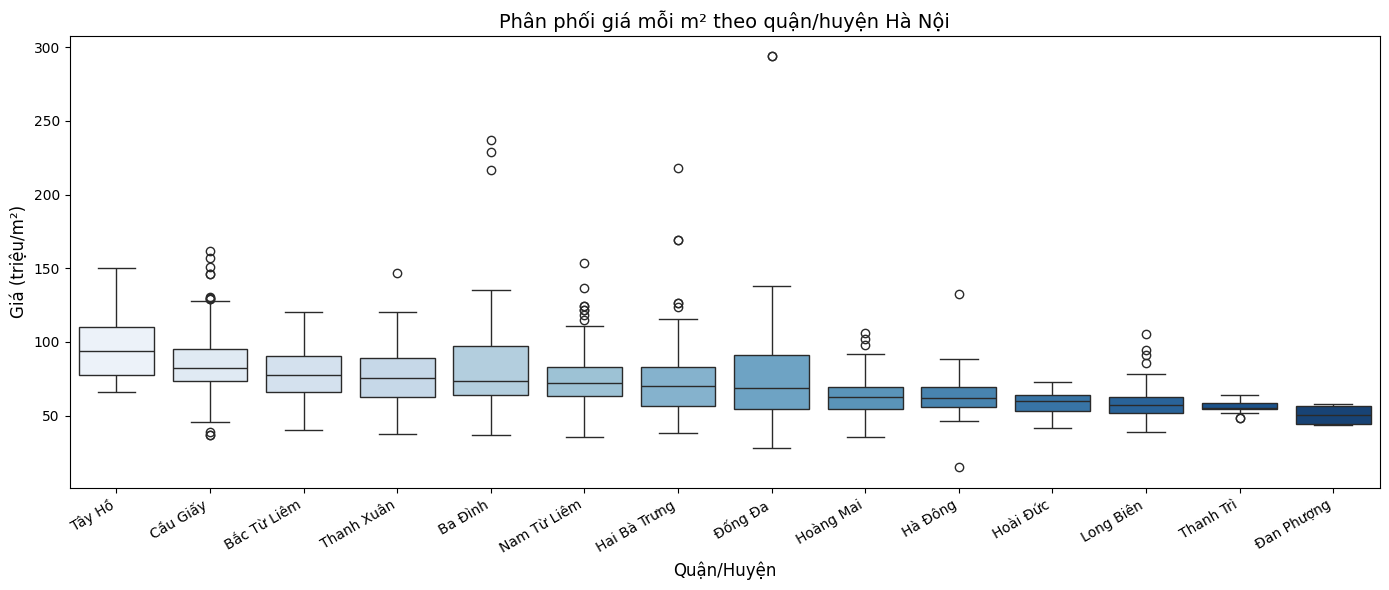

In [279]:

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_filtered,
    x="district",
    y="price_per_m2",
    palette="Blues",
    order=data.groupby("district")["price_per_m2"].median().sort_values(ascending=False).index  # sắp xếp quận theo giá
)

plt.title("Phân phối giá mỗi m² theo quận/huyện Hà Nội", fontsize=14)
plt.ylabel("Giá (triệu/m²)", fontsize=12)
plt.xlabel("Quận/Huyện", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


#### Giá trung bình căn hộ theo khu vực quận/huyện

C:\Users\ADM\AppData\Local\Temp\ipykernel_38132\509350066.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="Blues_d")


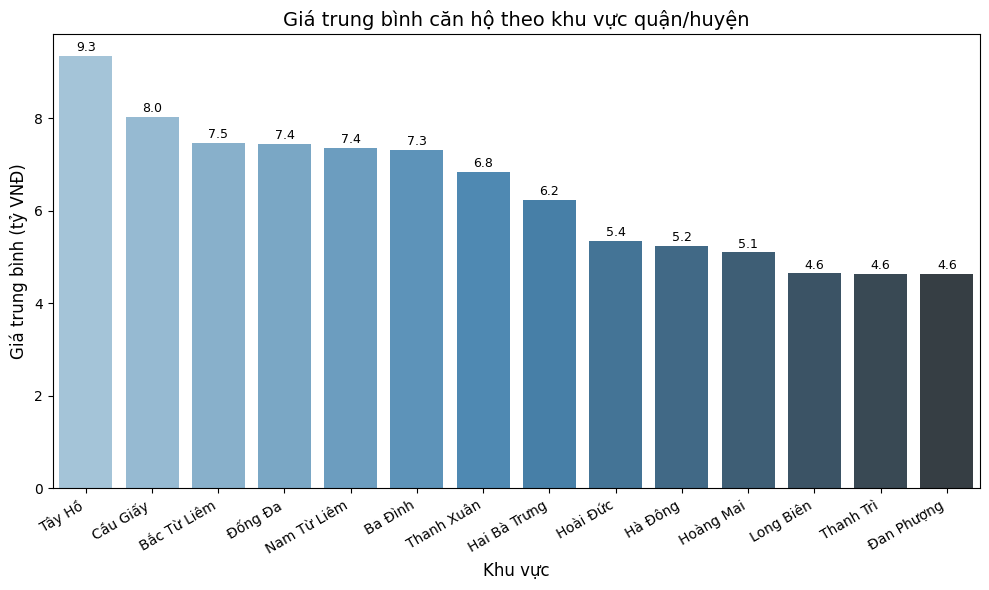

In [280]:
plt.figure(figsize=(10, 6))

# Tính giá trung bình theo khu vực
avg_price = df_filtered.groupby("district")["price_ty"].mean().sort_values(ascending=False)
for i, v in enumerate(avg_price.values):
    plt.text(i, v + 0.1, f"{v:.1f}", ha='center', fontsize=9)

sns.barplot(x=avg_price.index, y=avg_price.values, palette="Blues_d")

plt.title("Giá trung bình căn hộ theo khu vực quận/huyện", fontsize=14)
plt.xlabel("Khu vực", fontsize=12)
plt.ylabel("Giá trung bình (tỷ VNĐ)", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


#### Mối quan hệ giữa diện tích và giá căn hộ

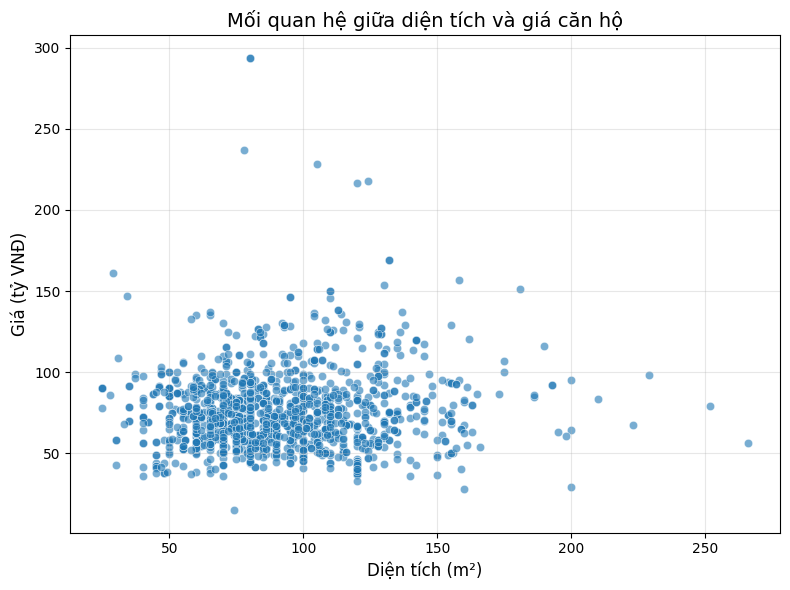

In [281]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_filtered, x="area_m2", y="price_per_m2", alpha=0.6, color="#1f77b4")

plt.title("Mối quan hệ giữa diện tích và giá căn hộ", fontsize=14)
plt.xlabel("Diện tích (m²)", fontsize=12)
plt.ylabel("Giá (tỷ VNĐ)", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### Ảnh hưởng của số phòng ngủ đến giá căn hộ

C:\Users\ADM\AppData\Local\Temp\ipykernel_38132\4140468259.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x="bedrooms", y="price_ty", palette="Set2")


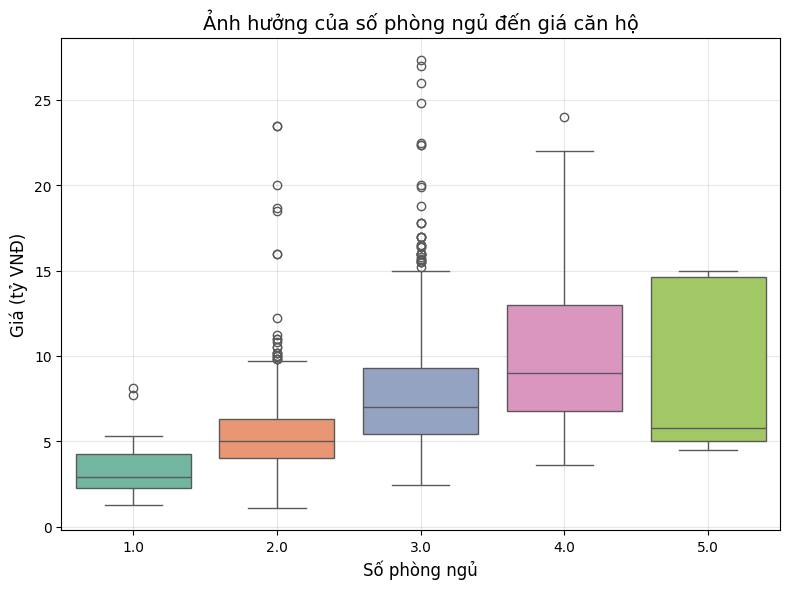

In [282]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtered, x="bedrooms", y="price_ty", palette="Set2")

plt.title("Ảnh hưởng của số phòng ngủ đến giá căn hộ", fontsize=14)
plt.xlabel("Số phòng ngủ", fontsize=12)
plt.ylabel("Giá (tỷ VNĐ)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Correlation Matrix (Giá, Diện tích, Phòng ngủ, Nội thành)

                price_ty   area_m2  bedrooms  urban_district
price_ty        1.000000  0.722019  0.424540        0.094384
area_m2         0.722019  1.000000  0.663240        0.011502
bedrooms        0.424540  0.663240  1.000000       -0.017741
urban_district  0.094384  0.011502 -0.017741        1.000000


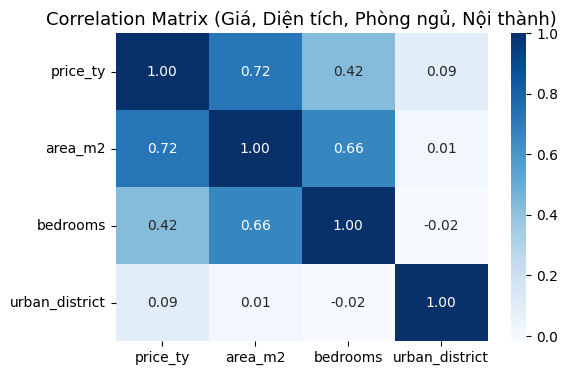

In [283]:
corr_cols = ["price_ty", "area_m2", "bedrooms", "urban_district"]

corr_matrix = df_filtered[corr_cols].corr()
print(corr_matrix)

# Vẽ heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix (Giá, Diện tích, Phòng ngủ, Nội thành)", fontsize=13)
plt.show()
